In [33]:
import cv2
import numpy as np
from matplotlib import pyplot as plt


Loading and resizing images to (256, 256)...
Background image loaded. Shape: (256, 256, 3)
Test image loaded. Shape: (256, 256, 3)

Feature extraction complete.
Background features shape (N_samples, d_features): (65536, 3)
Test features shape (N_samples, d_features): (65536, 3)


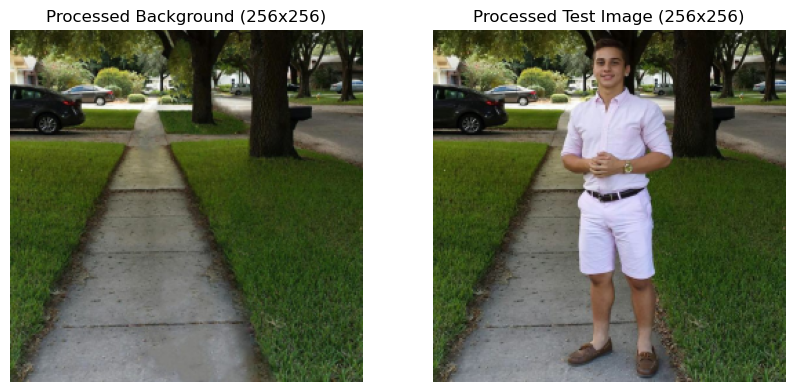

In [34]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- 1.1 Image Pre-Processing ---

def preprocess_image_rgb(image_path, target_size=(256, 256)):
    """
    Args
        image_path (str): The file path to the image.
        target_size (tuple): The target (width, height) to resize to.
    """
    img = cv2.imread(image_path)
    img_resized = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
    return img_resized

# --- Task 1: Image Alignment and Resizing ---
BACKGROUND_IMG_PATH = 'Data/1/back.jpg'
TEST_IMG_PATH = 'Data/1/Full.jpg'

TARGET_DIM = (256, 256) 

print(f"Loading and resizing images to {TARGET_DIM}...")

bg_image = preprocess_image_rgb(BACKGROUND_IMG_PATH, TARGET_DIM)
test_image = preprocess_image_rgb(TEST_IMG_PATH, TARGET_DIM)

if bg_image is not None and test_image is not None:
    print(f"Background image loaded. Shape: {bg_image.shape}")
    print(f"Test image loaded. Shape: {test_image.shape}")

    # --- Task 2: Feature Extraction ---
    
    # For the KDE model, we need our data as a 2D array where
    # each row is a sample (pixel) and each column is a feature.
    # Here, we have N = (W*H) samples and d=3 features (B, G, R).
    
    # Extract features for the KDE model (from the background image)
    # Shape will be (W*H, 3)
    bg_features = bg_image.reshape(-1, 3)
    
    # Extract features from the test image (to be evaluated by the KDE)
    # Shape will be (W*H, 3)
    test_features = test_image.reshape(-1, 3)
    
    print(f"\nFeature extraction complete.")
    print(f"Background features shape (N_samples, d_features): {bg_features.shape}")
    print(f"Test features shape (N_samples, d_features): {test_features.shape}")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    
    ax1.imshow(cv2.cvtColor(bg_image, cv2.COLOR_BGR2RGB))
    ax1.set_title(f'Processed Background ({TARGET_DIM[0]}x{TARGET_DIM[1]})')
    ax1.axis('off')
    
    ax2.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
    ax2.set_title(f'Processed Test Image ({TARGET_DIM[0]}x{TARGET_DIM[1]})')
    ax2.axis('off')
    
    plt.show()

else:
    print("\nSkipping feature extraction due to image loading errors.")
    print("Please check that your image paths are correct.")




1. Preprocessing Approach (Image Alignment and Resizing):

   Both images are resized to a uniform dimension (256x256). This is
   essential for:
   a) Alignment: It ensures a 1-to-1 correspondence between pixels for
      classification.

   b) Computational Efficiency: The KDE's cost scales with the number of
      data points (pixels). 256x256 is a good balance between detail
      and performance.


2. Feature Representation (RGB Channels):

   We are using the 3 color channels (B, G, R) as a 3-dimensional
   feature vector for each pixel.

   a) Richer Signal: This is a much stronger representation than
      grayscale. It captures color information (e.g., green grass,
      blue shirt, skin tone), which is a powerful differentiator
      between the foreground person and the background.

   b) Trade-off: This increases the feature dimensionality to d=3.
      This makes the KDE model (in Q1.2) more computationally
      expensive to fit and predict due to the "curse of dimensionality."
      However, the expected gain in segmentation accuracy justifies
      this cost.


In [35]:
class CustomKDE:
    # uses a sampling strategy in fit() to handle large datasets.
    
    def __init__(self, kernel='gaussian', bandwidth=1.0):
        """
        Args:
            kernel : 'gaussian', 'triangular', 'uniform'. 
            bandwidth: A positive float controlling smoothness. 
        """            
        self.kernel = kernel
        self.bandwidth = float(bandwidth)
        
        self.data = None  # Training data 
        self.n = 0        # Number of training samples
        self.d = 0        # Feature dimensionality
        
        # Mapping kernel names to their respective functions
        self._kernel_map = {
            'gaussian': self._k_gaussian,
            'triangular': self._k_triangular,
            'uniform': self._k_uniform
        }
        self.k_func = self._kernel_map[self.kernel]

    def fit(self, data, max_samples=10000):
        """
        Fits the KDE model to the provided data using a smart sampling strategy.
        
        Args:
            data (np.ndarray): The training data Should be shape (N_samples, N_features).
            max_samples (int): The maximum number of data points to store.
                               If data has more samples, a random subset is taken.
        """
        # Ensure data is 2D
        if data.ndim == 1:
            data = data.reshape(-1, 1)
        
        n_total = data.shape[0]
        
        # --- Smart Sampling Strategy ---
        if n_total > max_samples:
            # Randomly permute indices and take the first max_samples
            indices = np.random.permutation(n_total)[:max_samples]
            self.data = data[indices]
        else:
            self.data = data
        
        self.n = self.data.shape[0]
        self.d = self.data.shape[1]
        
        if self.n == 0:
            raise ValueError("No data provided to fit.")
            
        print(f"KDE fitted with {self.n} samples (d={self.d}) "
              f"using '{self.kernel}' kernel.")

    def predict(self, samples, batch_size=1024):
        """
        Predicts the probability density for a set of new sample points. 
        f_hat(x) = (1 / (n * h^d)) * sum[ K((x - xi) / h) ] 

        d is feature dimensionality,
        n is number of training samples,
        h is bandwidth,
        K is the kernel function,
        xi are training samples.
        
        Args:
            samples (np.ndarray): The points to evaluate Should be shape (M_samples, N_features).
            batch_size (int): Internal batch size for processing 'samples'
                              to avoid excessive memory usage.
                              
        Returns:
            np.ndarray: A 1D array of shape (M_samples,) containing the
                        estimated probability density for each sample.
        """

        m = samples.shape[0]  # Number of samples to predict
        densities = np.zeros(m)
        
        # Pre-calculate the constant factor: 1 / (n * h^d) 
        factor = 1.0 / (self.n * (self.bandwidth ** self.d))
        
        # Process in batches to avoid (m, n, d) memory explosion
        for i in range(0, m, batch_size):
            batch_start = i
            batch_end = min(i + batch_size, m)
            batch = samples[batch_start:batch_end]  # Shape (batch_size, d)
            
            # Use broadcasting to compute (x - xi) for all pairs
            # batch_exp shape: (batch_size, 1, d)
            # data_exp shape:  (1, n, d)
            # u shape:         (batch_size, n, d)
            batch_exp = batch[:, np.newaxis, :]
            data_exp = self.data[np.newaxis, :, :]
            
            # u = (x - xi) / h
            u = (batch_exp - data_exp) / self.bandwidth
            
            # Apply kernel K(u).
            # k_func handles the product over the d-dimensions.
            # k_values shape: (batch_size, n)
            k_values = self.k_func(u)
            
            # Sum over n (the training samples)
            # sum_k shape: (batch_size,)
            sum_k = np.sum(k_values, axis=1)
            densities[batch_start:batch_end] = factor * sum_k
            
        return densities

    # Each function takes an array 'u' of shape (..., d) and returns
    # an array of shape (...) by applying the 1D kernel along the
    # last dimension and taking the product.
    
    def _k_gaussian(self, u):
        """ Product of 1D Gaussian kernels. """
        # K(u) = (1/sqrt(2*pi)) * exp(-0.5 * u^2)
        term = (1.0 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * (u ** 2))
        return np.prod(term, axis=-1)

    def _k_triangular(self, u):
        """ Product of 1D Triangular kernels. """
        # K(u) = max(0, 1 - |u|)
        term = np.maximum(0, 1 - np.abs(u))
        return np.prod(term, axis=-1)

    def _k_uniform(self, u):
        """ Product of 1D Uniform (Box) kernels. """
        # K(u) = 1 if |u| <= 0.5, else 0
        term = np.where(np.abs(u) <= 0.5, 1.0, 0.0)
        return np.prod(term, axis=-1)

Experimenting with different bandwidths 
Running KDE: Kernel=gaussian, Bandwidth=5.0, Threshold=1.0e-08
KDE fitted with 10000 samples (d=3) using 'gaussian' kernel.
Running KDE: Kernel=gaussian, Bandwidth=15.0, Threshold=1.0e-08
KDE fitted with 10000 samples (d=3) using 'gaussian' kernel.
Running KDE: Kernel=gaussian, Bandwidth=30.0, Threshold=1.0e-08
KDE fitted with 10000 samples (d=3) using 'gaussian' kernel.


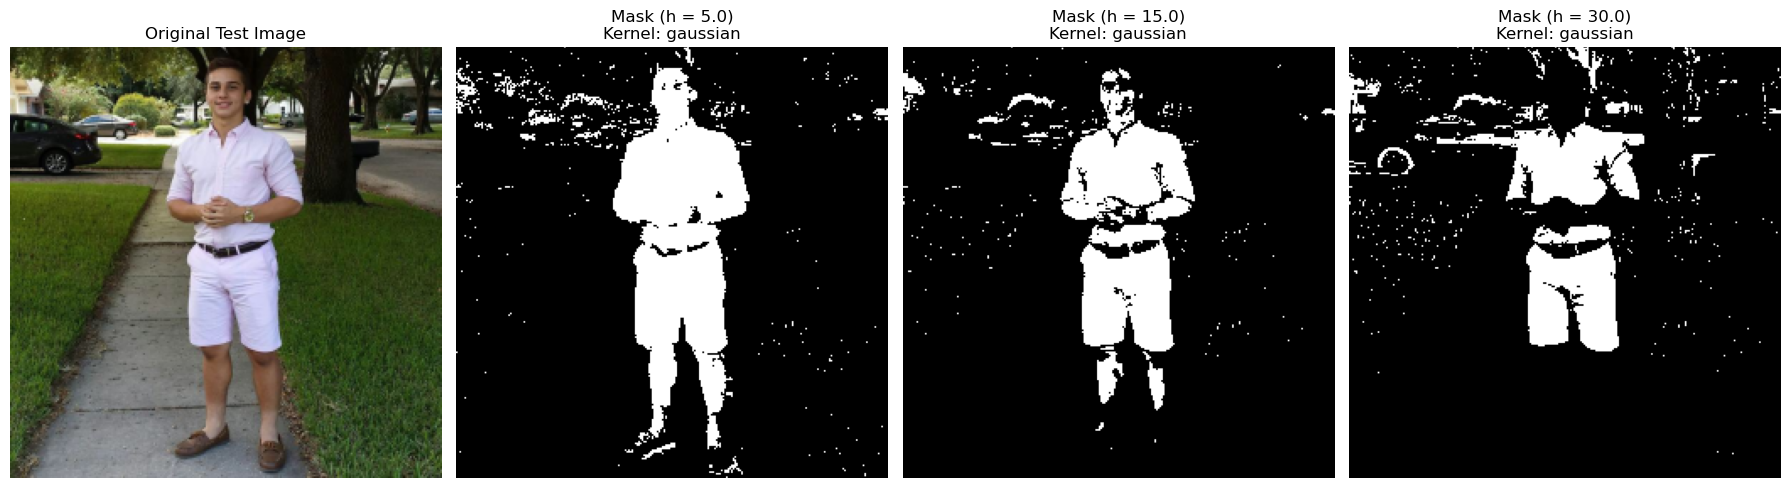


 Best Parameter Combination
Selected: Kernel=gaussian, Bandwidth=5, Threshold=1.0e-08
Running KDE: Kernel=gaussian, Bandwidth=5, Threshold=1.0e-08
KDE fitted with 10000 samples (d=3) using 'gaussian' kernel.


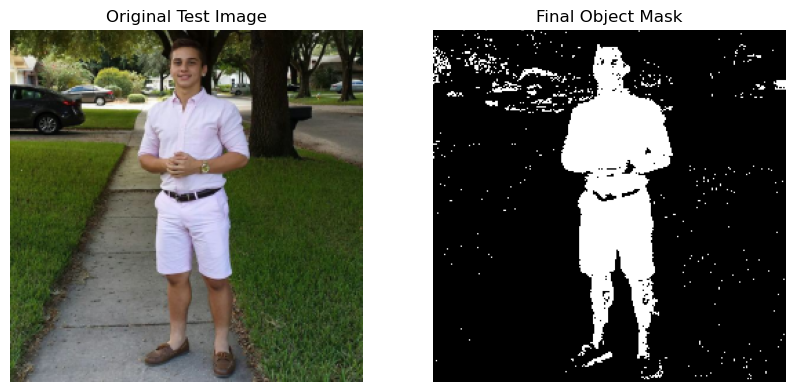

In [36]:
def perform_foreground_detection(bg_data, test_data, image_shape, kernel, bandwidth, threshold, max_fit_samples=10000):
    
    #Fits a KDE on background data and detects foreground in test data.
    print(f"Running KDE: Kernel={kernel}, Bandwidth={bandwidth}, Threshold={threshold:.1e}")
    
    # 1. Fit the KDE model on the background image features 
    kde = CustomKDE(kernel=kernel, bandwidth=bandwidth)
    kde.fit(bg_data, max_samples=max_fit_samples)
    
    # 2. Predict the density values for each pixel in the test image 
    # This returns p(pixel | Background)
    densities = kde.predict(test_data)
    
    # 3. Classify pixels based on the threshold
    # If p(pixel | Background) is VERY LOW (below threshold),
    # it is "unlikely" to be background, so we classify it as FOREGROUND.
    is_foreground = densities < threshold
    
    # Reshape the 1D boolean mask back into a 2D image
    # We multiply by 255 to make the foreground (True) white
    image_h, image_w = image_shape[1], image_shape[0] # (H, W)
    object_mask = is_foreground.reshape((image_h, image_w)).astype(np.uint8) * 255
    
    return object_mask, densities
# We will hold the kernel and threshold constant to observe the effect of the most critical parameter: bandwidth.

experiment_kernel = 'gaussian'
experiment_threshold = 1e-8  # This is a density, so it's very small
bandwidths_to_test = [5.0,15.0, 30.0]

fig, axes = plt.subplots(1, len(bandwidths_to_test) + 1, figsize=(18, 5))

axes[0].imshow(test_image[..., ::-1])
axes[0].set_title("Original Test Image")
axes[0].axis('off')



print("Experimenting with different bandwidths ")

for i, bw in enumerate(bandwidths_to_test):
    ax = axes[i + 1]
    
    try:
        # Run the full process
        mask, _ = perform_foreground_detection(
            bg_data=bg_features,
            test_data=test_features,
            image_shape=TARGET_DIM,
            kernel=experiment_kernel,
            bandwidth=bw,
            threshold=experiment_threshold
        )
        
        # Plot the resulting object mask
        ax.imshow(mask, cmap='gray')
        title = f"Mask (h = {bw})\nKernel: {experiment_kernel}"
    
    except NameError:
        title = "Error: Run Q1.1/Q1.2 cells"
        pass
    
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()

print("\n Best Parameter Combination")
BEST_KERNEL = 'gaussian'
BEST_BANDWIDTH = 5
BEST_THRESHOLD = 1e-8  # requires tuning 

print(f"Selected: Kernel={BEST_KERNEL}, Bandwidth={BEST_BANDWIDTH}, Threshold={BEST_THRESHOLD:.1e}")

best_mask, densities = perform_foreground_detection(
    bg_data=bg_features,
    test_data=test_features,
    image_shape=(TARGET_DIM[1], TARGET_DIM[0]),  # (H, W)
    kernel=BEST_KERNEL,
    bandwidth=BEST_BANDWIDTH,
    threshold=BEST_THRESHOLD
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    
ax1.imshow(test_image[..., ::-1])  
ax1.set_title("Original Test Image")
ax1.axis('off')
    
ax2.imshow(best_mask, cmap='gray')
ax2.set_title("Final Object Mask")
ax2.axis('off')
    
plt.show()
